In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

The dataset is about forest fire in Portugal, detailed information can be found here:
http://archive.ics.uci.edu/ml/datasets/Forest+Fires

## Atribut Information

For more information, read [Cortez and Morais, 2007].
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

In [2]:
data = pd.read_csv('../dataset/forestfires.csv')

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
data.shape

(517, 13)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Boosting - XGBoost

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [29]:
obj_cols = [col for col in data.columns if data[col].dtype == "object"]
num_cols = [col for col in data.columns if data[col].dtype != "object"]

In [30]:
cols_with_missing = [col for col in data.columns
                     if data[col].isnull().any()]

cols_with_missing

[]

In [31]:
y = data.area
X = data.drop(['area','X','Y'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4,
                                                                random_state=42)

In [32]:
ordinal_encoder = OrdinalEncoder()
X_train[obj_cols] = ordinal_encoder.fit_transform(X_train[obj_cols])
X_valid[obj_cols] = ordinal_encoder.transform(X_valid[obj_cols])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [33]:
model = XGBRegressor(learning_rate=0.1, n_jobs=1)

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model.fit(X_train, y_train,  
          eval_metric=["rmse"],
          eval_set=eval_set,
          verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred = model.predict(X_valid)

In [35]:
y_pred[0:5]

array([ 7.492188  ,  0.22153896,  8.83019   , 22.573566  , 23.007816  ],
      dtype=float32)

In [36]:
mean_squared_error(y_valid, y_pred, squared=False)

120.77839882149883

In [37]:
y_valid[0:5]

304    0.00
501    0.00
441    1.23
153    1.46
503    1.95
Name: area, dtype: float64

In [38]:
y.mean()

12.847292069632491

In [39]:
y_pred.mean()

20.643028

In [40]:
y_train.mean()

11.285709677419346

In [41]:
y_valid.mean()

15.185893719806765

# SVR

In [42]:
from sklearn.svm import SVR

In [43]:
model = SVR()
model.fit(X_train,y_train)

SVR()

In [44]:
y_pred = model.predict(X_valid)

In [45]:
mean_squared_error(y_valid, y_pred, squared=False)

82.5806844638773

In [46]:
y_pred.mean()

0.557952460163696

In [47]:
y_train.mean()

11.285709677419346

In [48]:
y_valid.mean()

15.185893719806765

# NN

In [125]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=3, activation='relu', input_shape=[10]),
    # the linear output layer 
    layers.Dense(units=1),
])

In [126]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 4         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

In [128]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=132,
    epochs=1000,
)

Epoch 1/1000
3/3 [==============================] - 0s 39ms/step - loss: 6214906368.0000 - root_mean_squared_error: 78834.6797 - val_loss: 4841629.5000 - val_root_mean_squared_error: 2200.3704
Epoch 2/1000
3/3 [==============================] - 0s 9ms/step - loss: 4683369.0000 - root_mean_squared_error: 2164.1094 - val_loss: 4289952.0000 - val_root_mean_squared_error: 2071.2200
Epoch 3/1000
3/3 [==============================] - 0s 8ms/step - loss: 4148464.0000 - root_mean_squared_error: 2036.7778 - val_loss: 3802073.0000 - val_root_mean_squared_error: 1949.8905
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 3675322.2500 - root_mean_squared_error: 1917.1130 - val_loss: 3369607.5000 - val_root_mean_squared_error: 1835.6490
Epoch 5/1000
3/3 [==============================] - 0s 10ms/step - loss: 3255877.0000 - root_mean_squared_error: 1804.4049 - val_loss: 2985710.7500 - val_root_mean_squared_error: 1727.9209
Epoch 6/1000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 9ms/step - loss: 27860.2676 - root_mean_squared_error: 166.9140 - val_loss: 31086.8867 - val_root_mean_squared_error: 176.3147
Epoch 46/1000
3/3 [==============================] - 0s 15ms/step - loss: 24941.4141 - root_mean_squared_error: 157.9285 - val_loss: 28361.7109 - val_root_mean_squared_error: 168.4094
Epoch 47/1000
3/3 [==============================] - 0s 7ms/step - loss: 22363.5410 - root_mean_squared_error: 149.5444 - val_loss: 25955.9980 - val_root_mean_squared_error: 161.1087
Epoch 48/1000
3/3 [==============================] - 0s 7ms/step - loss: 20088.8457 - root_mean_squared_error: 141.7351 - val_loss: 23816.2578 - val_root_mean_squared_error: 154.3252
Epoch 49/1000
3/3 [==============================] - 0s 7ms/step - loss: 18062.6621 - root_mean_squared_error: 134.3974 - val_loss: 21868.6406 - val_root_mean_squared_error: 147.8805
Epoch 50/1000
3/3 [==============================] - 0s 8ms/step - loss: 16229.9775 - root_mean_sq

3/3 [==============================] - 0s 9ms/step - loss: 2437.5317 - root_mean_squared_error: 49.3714 - val_loss: 6797.0542 - val_root_mean_squared_error: 82.4443
Epoch 91/1000
3/3 [==============================] - 0s 11ms/step - loss: 2422.2505 - root_mean_squared_error: 49.2164 - val_loss: 6782.9990 - val_root_mean_squared_error: 82.3590
Epoch 92/1000
3/3 [==============================] - 0s 8ms/step - loss: 2412.0969 - root_mean_squared_error: 49.1131 - val_loss: 6764.5791 - val_root_mean_squared_error: 82.2471
Epoch 93/1000
3/3 [==============================] - 0s 9ms/step - loss: 2400.1094 - root_mean_squared_error: 48.9909 - val_loss: 6753.8936 - val_root_mean_squared_error: 82.1821
Epoch 94/1000
3/3 [==============================] - 0s 8ms/step - loss: 2392.8958 - root_mean_squared_error: 48.9172 - val_loss: 6742.5342 - val_root_mean_squared_error: 82.1129
Epoch 95/1000
3/3 [==============================] - 0s 7ms/step - loss: 2385.6194 - root_mean_squared_error: 48.8428 

3/3 [==============================] - 0s 6ms/step - loss: 2327.7913 - root_mean_squared_error: 48.2472 - val_loss: 6628.8213 - val_root_mean_squared_error: 81.4176
Epoch 136/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.7285 - root_mean_squared_error: 48.2465 - val_loss: 6628.9976 - val_root_mean_squared_error: 81.4187
Epoch 137/1000
3/3 [==============================] - 0s 8ms/step - loss: 2328.0913 - root_mean_squared_error: 48.2503 - val_loss: 6629.2695 - val_root_mean_squared_error: 81.4203
Epoch 138/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.8674 - root_mean_squared_error: 48.2480 - val_loss: 6629.0669 - val_root_mean_squared_error: 81.4191
Epoch 139/1000
3/3 [==============================] - 0s 7ms/step - loss: 2328.0220 - root_mean_squared_error: 48.2496 - val_loss: 6628.3848 - val_root_mean_squared_error: 81.4149
Epoch 140/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.5740 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 8ms/step - loss: 2327.3389 - root_mean_squared_error: 48.2425 - val_loss: 6625.3242 - val_root_mean_squared_error: 81.3961
Epoch 181/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2483 - root_mean_squared_error: 48.2416 - val_loss: 6624.0220 - val_root_mean_squared_error: 81.3881
Epoch 182/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1416 - root_mean_squared_error: 48.2405 - val_loss: 6624.0972 - val_root_mean_squared_error: 81.3886
Epoch 183/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.5225 - root_mean_squared_error: 48.2444 - val_loss: 6624.5493 - val_root_mean_squared_error: 81.3913
Epoch 184/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1262 - root_mean_squared_error: 48.2403 - val_loss: 6625.0972 - val_root_mean_squared_error: 81.3947
Epoch 185/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3052 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 7ms/step - loss: 2327.3105 - root_mean_squared_error: 48.2422 - val_loss: 6623.7275 - val_root_mean_squared_error: 81.3863
Epoch 226/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0300 - root_mean_squared_error: 48.2393 - val_loss: 6623.9946 - val_root_mean_squared_error: 81.3879
Epoch 227/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.4250 - root_mean_squared_error: 48.2434 - val_loss: 6622.2246 - val_root_mean_squared_error: 81.3771
Epoch 228/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0369 - root_mean_squared_error: 48.2394 - val_loss: 6622.6719 - val_root_mean_squared_error: 81.3798
Epoch 229/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1978 - root_mean_squared_error: 48.2410 - val_loss: 6621.5186 - val_root_mean_squared_error: 81.3727
Epoch 230/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.4080 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.0354 - root_mean_squared_error: 48.2394 - val_loss: 6623.6299 - val_root_mean_squared_error: 81.3857
Epoch 271/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2588 - root_mean_squared_error: 48.2417 - val_loss: 6623.7935 - val_root_mean_squared_error: 81.3867
Epoch 272/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3047 - root_mean_squared_error: 48.2421 - val_loss: 6624.3618 - val_root_mean_squared_error: 81.3902
Epoch 273/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.4055 - root_mean_squared_error: 48.2432 - val_loss: 6624.7935 - val_root_mean_squared_error: 81.3928
Epoch 274/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1748 - root_mean_squared_error: 48.2408 - val_loss: 6625.2017 - val_root_mean_squared_error: 81.3953
Epoch 275/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.5237 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.3340 - root_mean_squared_error: 48.2425 - val_loss: 6621.7065 - val_root_mean_squared_error: 81.3739
Epoch 316/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.1228 - root_mean_squared_error: 48.2403 - val_loss: 6622.3081 - val_root_mean_squared_error: 81.3776
Epoch 317/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3079 - root_mean_squared_error: 48.2422 - val_loss: 6623.1128 - val_root_mean_squared_error: 81.3825
Epoch 318/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0164 - root_mean_squared_error: 48.2392 - val_loss: 6623.3291 - val_root_mean_squared_error: 81.3838
Epoch 319/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1313 - root_mean_squared_error: 48.2403 - val_loss: 6623.9614 - val_root_mean_squared_error: 81.3877
Epoch 320/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0730 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.3052 - root_mean_squared_error: 48.2422 - val_loss: 6620.6958 - val_root_mean_squared_error: 81.3677
Epoch 361/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1030 - root_mean_squared_error: 48.2401 - val_loss: 6621.0679 - val_root_mean_squared_error: 81.3699
Epoch 362/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0151 - root_mean_squared_error: 48.2391 - val_loss: 6621.4160 - val_root_mean_squared_error: 81.3721
Epoch 363/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1455 - root_mean_squared_error: 48.2405 - val_loss: 6621.3936 - val_root_mean_squared_error: 81.3719
Epoch 364/1000
3/3 [==============================] - 0s 9ms/step - loss: 2327.2375 - root_mean_squared_error: 48.2415 - val_loss: 6621.3154 - val_root_mean_squared_error: 81.3715
Epoch 365/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1604 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 11ms/step - loss: 2327.1624 - root_mean_squared_error: 48.2407 - val_loss: 6621.5264 - val_root_mean_squared_error: 81.3728
Epoch 406/1000
3/3 [==============================] - 0s 8ms/step - loss: 2327.2776 - root_mean_squared_error: 48.2419 - val_loss: 6622.0259 - val_root_mean_squared_error: 81.3758
Epoch 407/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0178 - root_mean_squared_error: 48.2392 - val_loss: 6622.2959 - val_root_mean_squared_error: 81.3775
Epoch 408/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1880 - root_mean_squared_error: 48.2409 - val_loss: 6621.9258 - val_root_mean_squared_error: 81.3752
Epoch 409/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2605 - root_mean_squared_error: 48.2417 - val_loss: 6622.5684 - val_root_mean_squared_error: 81.3792
Epoch 410/1000
3/3 [==============================] - 0s 8ms/step - loss: 2327.3628 - root_mean_squared_error: 48.

3/3 [==============================] - 0s 8ms/step - loss: 2327.1179 - root_mean_squared_error: 48.2402 - val_loss: 6620.6274 - val_root_mean_squared_error: 81.3672
Epoch 451/1000
3/3 [==============================] - 0s 8ms/step - loss: 2327.2104 - root_mean_squared_error: 48.2412 - val_loss: 6621.1460 - val_root_mean_squared_error: 81.3704
Epoch 452/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2520 - root_mean_squared_error: 48.2416 - val_loss: 6619.9058 - val_root_mean_squared_error: 81.3628
Epoch 453/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1743 - root_mean_squared_error: 48.2408 - val_loss: 6619.9189 - val_root_mean_squared_error: 81.3629
Epoch 454/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.5593 - root_mean_squared_error: 48.2448 - val_loss: 6618.4893 - val_root_mean_squared_error: 81.3541
Epoch 455/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2798 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.4680 - root_mean_squared_error: 48.2438 - val_loss: 6623.1753 - val_root_mean_squared_error: 81.3829
Epoch 496/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3254 - root_mean_squared_error: 48.2424 - val_loss: 6623.2295 - val_root_mean_squared_error: 81.3832
Epoch 497/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1025 - root_mean_squared_error: 48.2401 - val_loss: 6623.3247 - val_root_mean_squared_error: 81.3838
Epoch 498/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0864 - root_mean_squared_error: 48.2399 - val_loss: 6623.1758 - val_root_mean_squared_error: 81.3829
Epoch 499/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3123 - root_mean_squared_error: 48.2422 - val_loss: 6624.0220 - val_root_mean_squared_error: 81.3881
Epoch 500/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2104 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 5ms/step - loss: 2327.0435 - root_mean_squared_error: 48.2394 - val_loss: 6620.8062 - val_root_mean_squared_error: 81.3683
Epoch 541/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.1743 - root_mean_squared_error: 48.2408 - val_loss: 6621.3760 - val_root_mean_squared_error: 81.3718
Epoch 542/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2502 - root_mean_squared_error: 48.2416 - val_loss: 6621.3936 - val_root_mean_squared_error: 81.3719
Epoch 543/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.3350 - root_mean_squared_error: 48.2425 - val_loss: 6622.0923 - val_root_mean_squared_error: 81.3762
Epoch 544/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2908 - root_mean_squared_error: 48.2420 - val_loss: 6620.8672 - val_root_mean_squared_error: 81.3687
Epoch 545/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.0305 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.7249 - root_mean_squared_error: 48.2465 - val_loss: 6622.1270 - val_root_mean_squared_error: 81.3764
Epoch 586/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.1643 - root_mean_squared_error: 48.2407 - val_loss: 6621.7969 - val_root_mean_squared_error: 81.3744
Epoch 587/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.2009 - root_mean_squared_error: 48.2411 - val_loss: 6622.0029 - val_root_mean_squared_error: 81.3757
Epoch 588/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1228 - root_mean_squared_error: 48.2403 - val_loss: 6622.5527 - val_root_mean_squared_error: 81.3791
Epoch 589/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3872 - root_mean_squared_error: 48.2430 - val_loss: 6622.3115 - val_root_mean_squared_error: 81.3776
Epoch 590/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0693 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.4141 - root_mean_squared_error: 48.2433 - val_loss: 6619.0059 - val_root_mean_squared_error: 81.3573
Epoch 631/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1721 - root_mean_squared_error: 48.2408 - val_loss: 6619.7427 - val_root_mean_squared_error: 81.3618
Epoch 632/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1836 - root_mean_squared_error: 48.2409 - val_loss: 6620.4595 - val_root_mean_squared_error: 81.3662
Epoch 633/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.5298 - root_mean_squared_error: 48.2445 - val_loss: 6620.9946 - val_root_mean_squared_error: 81.3695
Epoch 634/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3032 - root_mean_squared_error: 48.2421 - val_loss: 6619.6641 - val_root_mean_squared_error: 81.3613
Epoch 635/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.2690 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.4133 - root_mean_squared_error: 48.2433 - val_loss: 6621.4053 - val_root_mean_squared_error: 81.3720
Epoch 676/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0933 - root_mean_squared_error: 48.2400 - val_loss: 6621.1021 - val_root_mean_squared_error: 81.3702
Epoch 677/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0566 - root_mean_squared_error: 48.2396 - val_loss: 6621.0757 - val_root_mean_squared_error: 81.3700
Epoch 678/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.6218 - root_mean_squared_error: 48.2454 - val_loss: 6621.9365 - val_root_mean_squared_error: 81.3753
Epoch 679/1000
3/3 [==============================] - 0s 5ms/step - loss: 2326.9641 - root_mean_squared_error: 48.2386 - val_loss: 6621.9238 - val_root_mean_squared_error: 81.3752
Epoch 680/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.1091 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.3213 - root_mean_squared_error: 48.2423 - val_loss: 6624.8960 - val_root_mean_squared_error: 81.3935
Epoch 721/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.4797 - root_mean_squared_error: 48.2440 - val_loss: 6624.8882 - val_root_mean_squared_error: 81.3934
Epoch 722/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2190 - root_mean_squared_error: 48.2413 - val_loss: 6625.3169 - val_root_mean_squared_error: 81.3960
Epoch 723/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3162 - root_mean_squared_error: 48.2423 - val_loss: 6625.8438 - val_root_mean_squared_error: 81.3993
Epoch 724/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1726 - root_mean_squared_error: 48.2408 - val_loss: 6625.5376 - val_root_mean_squared_error: 81.3974
Epoch 725/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3132 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.3896 - root_mean_squared_error: 48.2430 - val_loss: 6623.0186 - val_root_mean_squared_error: 81.3819
Epoch 766/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.0696 - root_mean_squared_error: 48.2397 - val_loss: 6623.5801 - val_root_mean_squared_error: 81.3854
Epoch 767/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1326 - root_mean_squared_error: 48.2404 - val_loss: 6623.6182 - val_root_mean_squared_error: 81.3856
Epoch 768/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.2112 - root_mean_squared_error: 48.2412 - val_loss: 6622.3115 - val_root_mean_squared_error: 81.3776
Epoch 769/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0474 - root_mean_squared_error: 48.2395 - val_loss: 6622.9551 - val_root_mean_squared_error: 81.3815
Epoch 770/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.4729 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.6931 - root_mean_squared_error: 48.2462 - val_loss: 6624.5527 - val_root_mean_squared_error: 81.3914
Epoch 811/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1135 - root_mean_squared_error: 48.2402 - val_loss: 6625.0508 - val_root_mean_squared_error: 81.3944
Epoch 812/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1313 - root_mean_squared_error: 48.2403 - val_loss: 6624.9678 - val_root_mean_squared_error: 81.3939
Epoch 813/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1284 - root_mean_squared_error: 48.2403 - val_loss: 6625.1362 - val_root_mean_squared_error: 81.3949
Epoch 814/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.1799 - root_mean_squared_error: 48.2409 - val_loss: 6624.2656 - val_root_mean_squared_error: 81.3896
Epoch 815/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0750 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.1008 - root_mean_squared_error: 48.2400 - val_loss: 6623.0342 - val_root_mean_squared_error: 81.3820
Epoch 856/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0845 - root_mean_squared_error: 48.2399 - val_loss: 6623.5078 - val_root_mean_squared_error: 81.3849
Epoch 857/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2148 - root_mean_squared_error: 48.2412 - val_loss: 6623.7148 - val_root_mean_squared_error: 81.3862
Epoch 858/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.0752 - root_mean_squared_error: 48.2398 - val_loss: 6624.2798 - val_root_mean_squared_error: 81.3897
Epoch 859/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.3276 - root_mean_squared_error: 48.2424 - val_loss: 6624.1729 - val_root_mean_squared_error: 81.3890
Epoch 860/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.2622 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 10ms/step - loss: 2327.3171 - root_mean_squared_error: 48.2423 - val_loss: 6626.9819 - val_root_mean_squared_error: 81.4063
Epoch 901/1000
3/3 [==============================] - 0s 11ms/step - loss: 2327.4131 - root_mean_squared_error: 48.2433 - val_loss: 6627.2119 - val_root_mean_squared_error: 81.4077
Epoch 902/1000
3/3 [==============================] - 0s 12ms/step - loss: 2327.4287 - root_mean_squared_error: 48.2434 - val_loss: 6627.0151 - val_root_mean_squared_error: 81.4065
Epoch 903/1000
3/3 [==============================] - 0s 9ms/step - loss: 2327.3748 - root_mean_squared_error: 48.2429 - val_loss: 6627.2686 - val_root_mean_squared_error: 81.4080
Epoch 904/1000
3/3 [==============================] - 0s 8ms/step - loss: 2327.4370 - root_mean_squared_error: 48.2435 - val_loss: 6626.6484 - val_root_mean_squared_error: 81.4042
Epoch 905/1000
3/3 [==============================] - 0s 7ms/step - loss: 2327.7817 - root_mean_squared_error: 4

3/3 [==============================] - 0s 5ms/step - loss: 2326.9817 - root_mean_squared_error: 48.2388 - val_loss: 6623.2656 - val_root_mean_squared_error: 81.3834
Epoch 946/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.3650 - root_mean_squared_error: 48.2428 - val_loss: 6621.5581 - val_root_mean_squared_error: 81.3730
Epoch 947/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.0691 - root_mean_squared_error: 48.2397 - val_loss: 6621.5220 - val_root_mean_squared_error: 81.3727
Epoch 948/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.1426 - root_mean_squared_error: 48.2405 - val_loss: 6621.9878 - val_root_mean_squared_error: 81.3756
Epoch 949/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.0305 - root_mean_squared_error: 48.2393 - val_loss: 6621.8115 - val_root_mean_squared_error: 81.3745
Epoch 950/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0100 - root_mean_squared_error: 48.2

3/3 [==============================] - 0s 6ms/step - loss: 2327.5576 - root_mean_squared_error: 48.2448 - val_loss: 6619.4214 - val_root_mean_squared_error: 81.3598
Epoch 991/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.2578 - root_mean_squared_error: 48.2417 - val_loss: 6619.9282 - val_root_mean_squared_error: 81.3629
Epoch 992/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.3848 - root_mean_squared_error: 48.2430 - val_loss: 6620.2300 - val_root_mean_squared_error: 81.3648
Epoch 993/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.1990 - root_mean_squared_error: 48.2411 - val_loss: 6620.6768 - val_root_mean_squared_error: 81.3675
Epoch 994/1000
3/3 [==============================] - 0s 5ms/step - loss: 2327.5146 - root_mean_squared_error: 48.2443 - val_loss: 6620.9443 - val_root_mean_squared_error: 81.3692
Epoch 995/1000
3/3 [==============================] - 0s 6ms/step - loss: 2327.0176 - root_mean_squared_error: 48.2

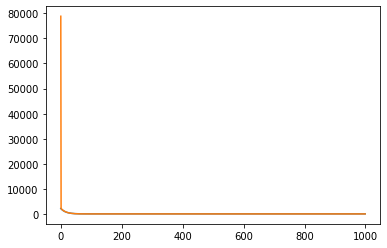

In [131]:
history_df = pd.DataFrame(history.history)
history_df['val_root_mean_squared_error'].plot();
history_df['root_mean_squared_error'].plot();

In [130]:
model.evaluate(X_valid, y_valid, verbose=False)

[6621.38818359375, 81.37191009521484]